In [1]:
# Copying all usefull libraries
import numpy as np
import gravmag as gmc
import auxiliars as aux
import matplotlib.pyplot as plt

In [2]:
# Definition for number of points and grid creation
npts = 500
x = np.linspace(-3000., 3000., npts)
y = np.copy(x)
z = -20.

# Creat the grid file
X, Y = np.meshgrid(x, y)

In [3]:
dx = x[1] - x[0]
dy = y[1] - y[0]

print(dx,dy)

12.0240480962 12.0240480962


In [24]:
#Informations about the rectangular prisms that we will use
prism = [-100., 100., -200., 200., 400., 1200., 1.275]

# Informations about the values for inclination and declination
direc = [45., 45.] # degreesprint 
field = [50., -22.] # degres
# Here we assume that both prism have the same inc and dec

In [25]:
# Calculate the total field anomaly
tfa = gmc.prism_tf(X, Y, z, prism, direc, field)

In [26]:
plt.figure()
plt.contourf(X, Y, tfa, 50, cmap = plt.cm.rainbow)
plt.colorbar()
plt.show()

In [27]:
fnew = [90., 0.]
snew = [90., 0.]

In [37]:
result = reduction(tfa, dx, dy, field, direc, fnew, snew)

In [38]:
plt.figure()
plt.contourf(X, Y, result, 50, cmap = plt.cm.rainbow)
plt.colorbar()
plt.show()

/home/rodbijani/anaconda3/lib/python3.4/site-packages/numpy/ma/core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [39]:
def reduction(data, dx, dy, field0, source0, field1, source1):
    '''
    '''
    # 1 - Verificar o tamanho do grid e se precisa expandir
    # 2 - Calcular os valores de nx, ny, dx e dy
    nx = data.shape[0]
    ny = data.shape[1]
    
    # Entra X e Y mas nao sao usados, verificar depois como fazer 
    # para entrar somente com eespçaamento
    kx = 2.0*np.pi* np.fft.fftfreq(nx, dx)
    ky = 2.0*np.pi* np.fft.fftfreq(ny, dy)
    KX, KY = np.meshgrid(kx, ky)
    
    #print(kx[0])
    #print(ky)
    #print(KX[0,0])
    #print(KY[0,0])
    
    # calculando a fft2
    fdata = np.fft.fft2(data)
    
    # calcular thetaM e thetaF - AQUI TAMBEM VAI ENTRAR OS VALORES DE KX E KY DO GRID
    theta_f0 = theta_calculated(field0, KX, KY)
    theta_m0 = theta_calculated(source0, KX, KY)
    theta_f1 = theta_calculated(field1, KX, KY)
    theta_m1 = theta_calculated(source1, KX, KY)
    
    #print(theta_m1)
    #print(theta_f1)
    
    # CALCULANDO A TRANSFORMACAO
    operator = (theta_f0 * theta_m0) / (theta_f1 * theta_m1)
    
    res = operator * fdata
    
    # excluindo o not a number
    res[0, 0] = 0    
    
    return np.real(np.fft.ifft2(res))

In [40]:
def theta_calculated(theta_in, kx, ky):
    '''
    '''
    # AQUI TAMBEM ENTRA KY E KY PRA PODER LEMBRAR
    
    # CHAMAR A DIRCOS PRA CALCULAR OS DIRETORES
    
    # calculando o modulo
    k = np.sqrt(kx**2 + ky**2)
    
    inc, dec = theta_in[0], theta_in[1]
    a, b, c = aux.dircos(inc, dec) # quando tiver no modulo, tirar o 'aux.'
    
    # calculando as projecoes
       
    d = (a*kx + b*ky)/k
    
    theta = c + d*1j
    
    theta[0,0] = 0.
    
    return theta

In [5]:
#Calculating the wavenumbers
u = 2.0*np.pi* np.fft.fftfreq(tfa.shape[0], x[1] - x[0])
v = 2.0*np.pi* np.fft.fftfreq(tfa.shape[1], y[1] - y[0])
U,V = np.meshgrid(u,v)

In [6]:
# Filtering the data
D = 250. # meters # H = 2000 - z > 0 - UPWARD!
TFA = np.fft.fft2(tfa) # Fourier transform for total field
K_up = np.exp(-(D-z)*(np.sqrt(U**2 + V**2))) # Filter calculation
TFA_cont = TFA*K_up # Applieding the filter
TFA_up = np.real(np.fft.ifft2(TFA_cont)) # Applieding the inverse Fourier

In [7]:
# Defines the valus for colorbar
print 'Minimum and maximum - first prism:', np.min(tfa1), '/', np.max(tfa1)
print 'Minimum and maximum - second prism:', np.min(tfa2),  '/', np.max(tfa2)
print 'Minimum and maximum - both prisms:', np.min(tfa),  '/', np.max(tfa)
print 'Minimum and maximum - upward data:', np.min(TFA_up),  '/', np.max(TFA_up)
values = [np.min(tfa1), np.max(tfa1), 
          np.min(tfa2), np.max(tfa2), 
          np.min(tfa), np.max(tfa), 
          np.min(TFA_up), np.max(TFA_up)]
print np.min(values)
print np.max(values)

# Defining the colorbar
vcor = np.linspace(tfa.min(), tfa.max(), 200)

Minimum and maximum - first prism: -380.785588959 / 157.070027995
Minimum and maximum - second prism: -475.535276749 / -29.4618443222
Minimum and maximum - both prisms: -506.746039165 / 81.1469596362
Minimum and maximum - upward data: -407.564273058 / -66.8462806951
-506.746039165
157.070027995


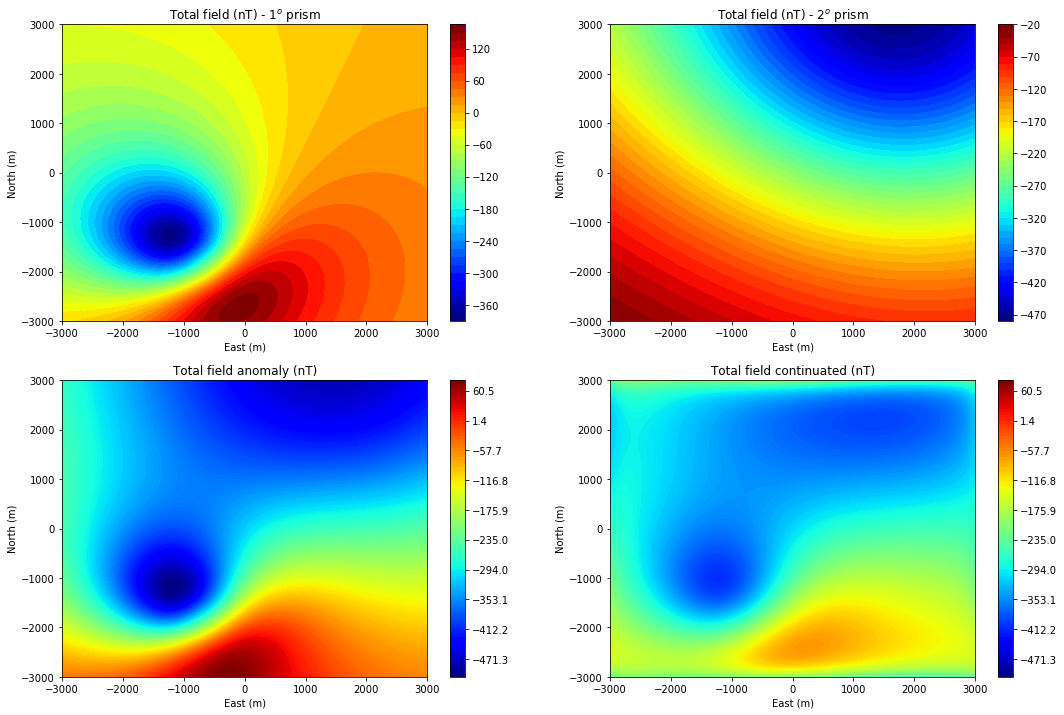

In [13]:
# Plot the map for total field anomaly
plt.close('all')
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
plt.title('Total field (nT) - $1^o$ prism')
fig1 = plt.contourf(X, Y, tfa1, 50, vmin = np.min(tfa1), vmax = np.max(tfa1), cmap = plt.cm.jet)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.xlim(np.min(X), np.max(X))
plt.ylim(np.min(Y), np.max(Y))
cb1 = plt.colorbar(fig1)
cb2lim = plt.clim(np.min(tfa1), np.max(tfa1))

plt.subplot(2,2,2)
plt.title('Total field (nT) - $2^o$ prism')
fig2 = plt.contourf(X, Y, tfa2, 50, cmap = plt.cm.jet, vmin = np.min(tfa2), vmax = np.max(tfa2))
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.xlim(np.min(X), np.max(X))
plt.ylim(np.min(Y), np.max(Y))
cb2 = plt.colorbar(fig2)
cb2lim = plt.clim(np.min(tfa2), np.max(tfa2))

plt.subplot(2,2,3)
plt.title('Total field anomaly (nT)')
fig3 = plt.contourf(X, Y, tfa, vcor, cmap = plt.cm.jet)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.xlim(np.min(X), np.max(X))
plt.ylim(np.min(Y), np.max(Y))
cb3 = plt.colorbar(fig3)
cb3lim = plt.clim(vcor.min(), vcor.max())

plt.subplot(2,2,4)
plt.title('Total field continuated (nT)')
fig4 = plt.contourf(X, Y, TFA_up, vcor, cmap = plt.cm.jet)
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.xlim(np.min(X), np.max(X))
plt.ylim(np.min(Y), np.max(Y))
cb4 = plt.colorbar(fig4)
cb4lim = plt.clim(vcor.min(), vcor.max())

plt.savefig('figs/magneticdata.png')
plt.show()